In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os
import signal
from dash import Dash, html, dcc
from dash.dependencies import Output, Input
from dash.exceptions import PreventUpdate
import plotly.offline as pyo

# Initialize plotly for notebooks
pyo.init_notebook_mode(connected=True)
pd.set_option('display.max_columns', None)

# Load the dataset

In [ ]:
data = pd.read_csv('spotify-2023.csv',encoding='ISO-8859-1')

In [ ]:
data.columns = ['track_name', 'artist_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'spotify_playlists_count',
       'spotify_charts_presence', 'streams', 'apple_playlists_count', 'apple_charts_presence',
       'deezer_playlists_count', 'deezer_charts_presence', 'shazam_charts_presence', 'bpm',
       'key', 'mode', 'danceability', 'valence', 'energy',
       'acousticness', 'instrumentalness', 'liveness', 'speechiness']

## Impute missing 'key' values based on the distribution of non-missing values

In [ ]:
key_count_data = pd.DataFrame(
data['key'].value_counts()
)
key_count_data['key'] = key_count_data.index

In [ ]:
valid_rows = key_count_data[key_count_data['key'] != -1]
total = valid_rows['count'].sum()
valid_rows['Probabilities'] = valid_rows['count'] / total

In [ ]:
num_minus_ones = 0
if -1 in key_count_data['key'].values:
    num_minus_ones = key_count_data[key_count_data['key'] == -1]['count'].iloc[0]
replacements = np.random.choice(valid_rows['key'], size=num_minus_ones, p=valid_rows['Probabilities'])

In [ ]:
data.loc[data['key'] == -1, 'key'] = replacements

In [ ]:
def encode_values(dataset, column, original_values):
    value_mapping = {original: value for value, original in enumerate(original_values)}
    dataset[column] = dataset[column].replace(value_mapping)

encode_values(data, 'key', data['key'].unique())
encode_values(data, 'mode', data['mode'].unique())

# Correlation analysis

In [ ]:
data_to_heatmap = data.copy()
data_to_heatmap.drop(columns=['track_name', 'artist_name'], inplace=True)
data_to_heatmap.drop([574], inplace=True)
data_to_heatmap['deezer_playlists_count'].fillna(0)
data_to_heatmap['deezer_charts_presence'].fillna(0)
data_to_heatmap['shazam_charts_presence'].fillna(0)
data_to_heatmap['deezer_playlists_count'] = data_to_heatmap['deezer_playlists_count'].replace(',', '').astype(int)
data_to_heatmap['shazam_charts_presence'] = data_to_heatmap['shazam_charts_presence'].str.replace(',', '').astype(float)

In [ ]:
data.drop([574],inplace=True)

<Axes: >

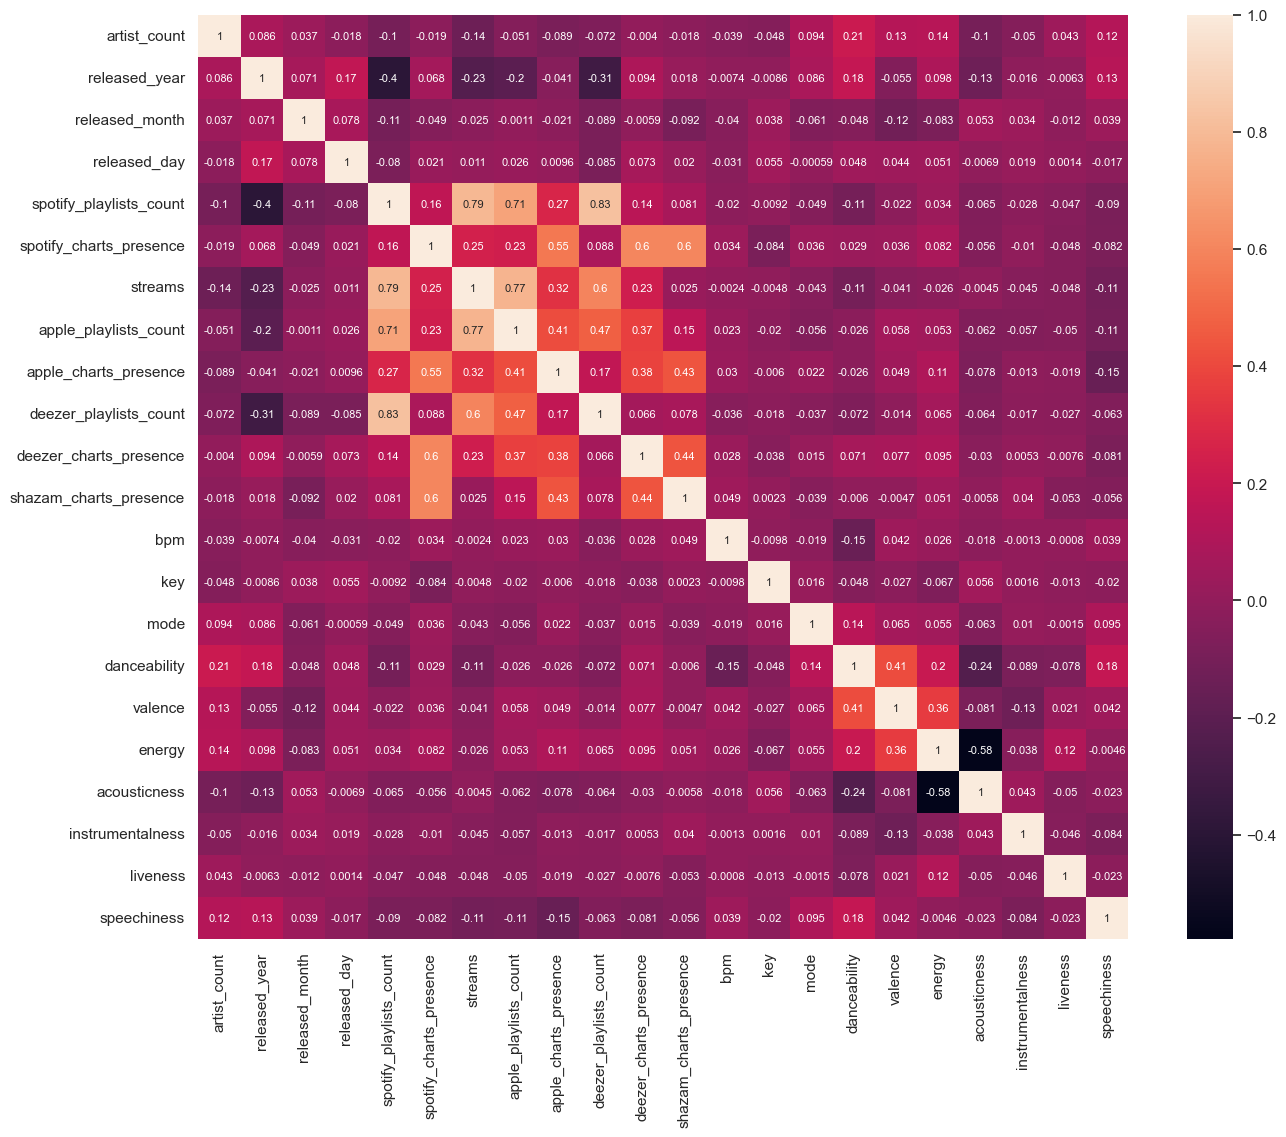

In [ ]:
corr = data_to_heatmap.corr()
sns.set(rc={'figure.figsize':(15,12)})
sns.heatmap(corr, annot=True, annot_kws={"size": 8})

# Conclusions
### Older songs are more likely to be on a playlist, for every music streaming service, as shown by the bigger negative correlations between year of launch and num of playlists;
### A music with more Acousticness have less energy;
### A music with more Danceability has more energy and more valence;
### A music that is in a lot of playlists from one of the music streaming services is high likely to be in a lot of playlists from the other services, as show by the high to very high correlation between them;
### High number of streams means high number of playlists with the music

# Data cleaning and processing

In [ ]:
data = data[~(data == 'BPM110KeyAModeMajorDanceability53Valence75Energy69Acousticness7Instrumentalness0Liveness17Speechiness3').any(axis=1)]
data['streams'] = data['streams'].astype(float)
data.drop_duplicates(subset='track_name', inplace=True)
data.sort_values(by=['streams'], ascending=False, inplace=True)

In [ ]:
data['artist_name'] = data["artist_name"].str.split(', ')

# Top 10 artists with the most tracks

In [ ]:
exploded_data = data.explode('artist_name')
artist_counts = exploded_data['artist_name'].value_counts().reset_index()
artist_counts.columns = ['artist_name', 'track_count']
top_artists = artist_counts.head(10)

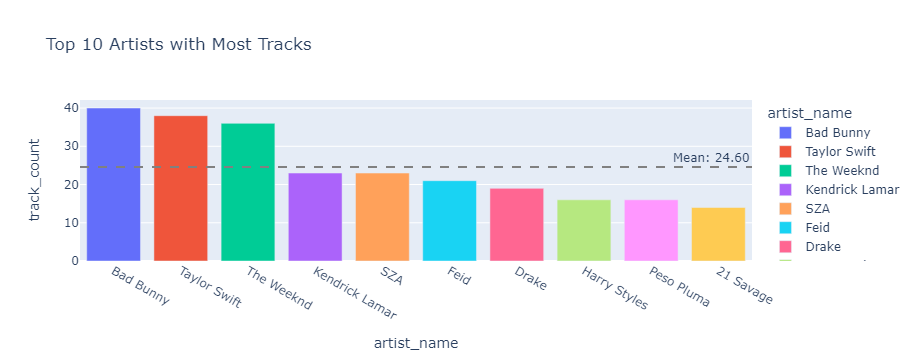

In [ ]:
fig_most_tracks = px.bar(top_artists, x='artist_name', y='track_count', title='Top 10 Artists with Most Tracks', color='artist_name')
mean_track_count = top_artists['track_count'].mean()
fig_most_tracks.add_hline(y=mean_track_count, line_dash='dash', line_color='grey', annotation_text=f"Mean: {mean_track_count:.2f}", annotation_position="top right")
fig_most_tracks.show()

# Top 10 artists with the most streams

In [ ]:
artist_stream_counts = exploded_data.groupby('artist_name')['streams'].sum().reset_index()
artist_stream_counts.columns = ['artist_name', 'streaming_count']
top_artists_streams = artist_stream_counts.sort_values(by='streaming_count', ascending=False).head(10)

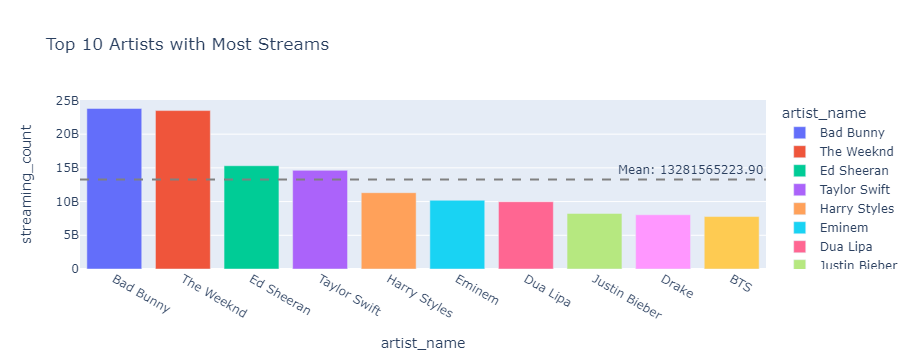

In [ ]:
fig_most_streams = px.bar(top_artists_streams, x='artist_name', y='streaming_count', title='Top 10 Artists with Most Streams', color='artist_name')
mean_stream_count = top_artists_streams['streaming_count'].mean()
fig_most_streams.add_hline(y=mean_stream_count, line_dash='dash', line_color='grey', annotation_text=f"Mean: {mean_stream_count:.2f}", annotation_position="top right")
fig_most_streams.show()

# Top 10 tracks by stream count

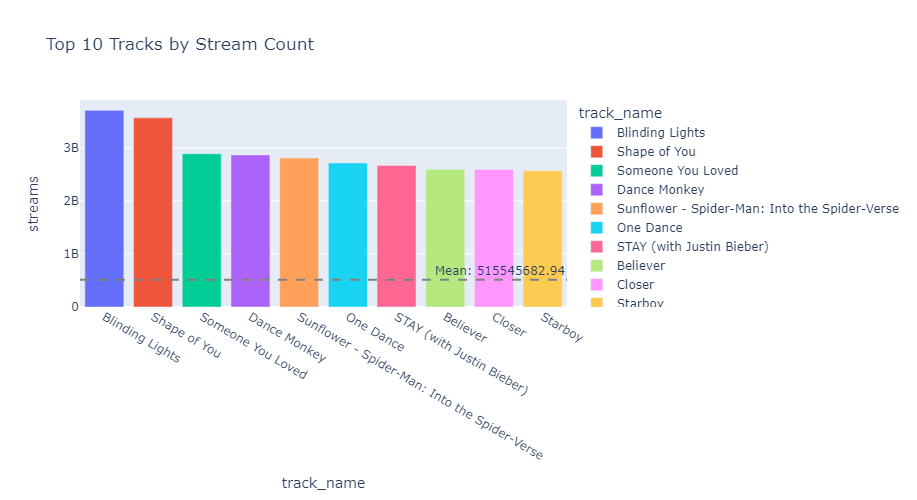

In [ ]:
fig_track_most_streams = px.bar(data.head(10), x='track_name', y='streams', title='Top 10 Tracks by Stream Count', color='track_name')
fig_track_most_streams.update_layout(width=1200, height=500)
mean_stream_count = data['streams'].mean()
fig_track_most_streams.add_hline(y=mean_stream_count, line_dash='dash', line_color='grey', annotation_text=f"Mean: {mean_stream_count:.2f}", annotation_position="top right")
fig_track_most_streams.show()

## Group and plot playlist appearances on Spotify, Apple Music and Deezer

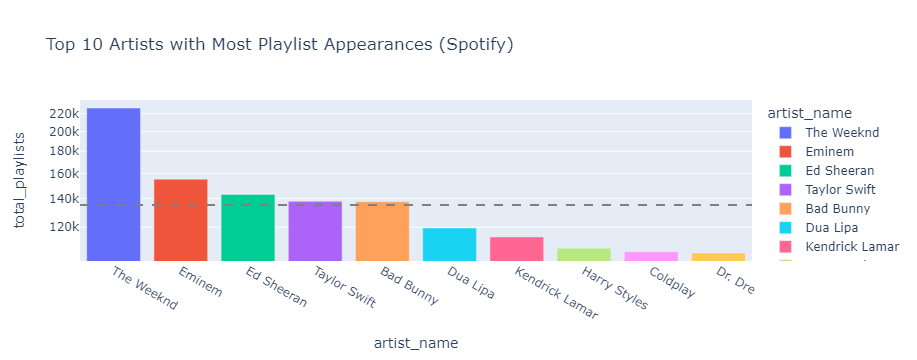

In [ ]:
exploded_data = data.explode('artist_name')
artist_playlist_counts = exploded_data.groupby('artist_name')['spotify_playlists_count'].sum().reset_index()
artist_playlist_counts['total_playlists'] = artist_playlist_counts['spotify_playlists_count']
top_artists_playlists = artist_playlist_counts.sort_values(by='total_playlists', ascending=False).head(10)
fig_playlist_spotify = px.bar(top_artists_playlists, x='artist_name', y='total_playlists', title='Top 10 Artists with Most Playlist Appearances (Spotify)', color='artist_name')
fig_playlist_spotify.update_layout(yaxis_type="log")
mean_playlist_count = top_artists_playlists['total_playlists'].mean()
fig_playlist_spotify.add_hline(y=mean_playlist_count, line_dash='dash', line_color='grey', annotation_text=f"Mean: {mean_playlist_count:.2f}", annotation_position="top right")
fig_playlist_spotify.show()

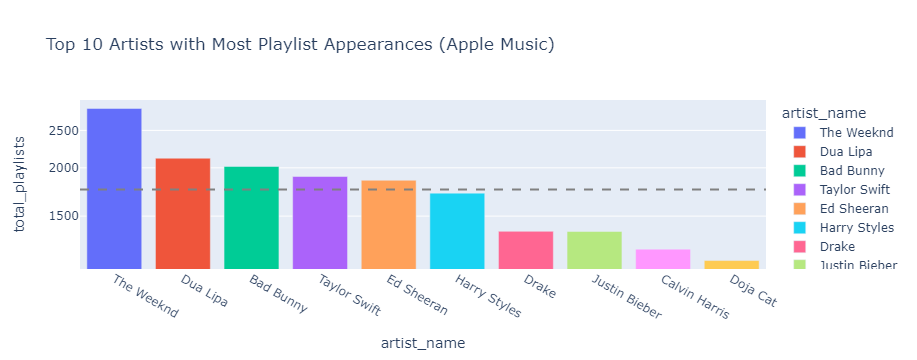

In [ ]:
artist_playlist_counts = exploded_data.groupby('artist_name')['apple_playlists_count'].sum().reset_index()
artist_playlist_counts['total_playlists'] = artist_playlist_counts['apple_playlists_count']
top_artists_playlists = artist_playlist_counts.sort_values(by='total_playlists', ascending=False).head(10)
fig_playlist_apple = px.bar(top_artists_playlists, x='artist_name', y='total_playlists', title='Top 10 Artists with Most Playlist Appearances (Apple Music)', color='artist_name')
fig_playlist_apple.update_layout(yaxis_type="log")
mean_playlist_count = top_artists_playlists['total_playlists'].mean()
fig_playlist_apple.add_hline(y=mean_playlist_count, line_dash='dash', line_color='grey', annotation_text=f"Mean: {mean_playlist_count:.2f}", annotation_position="top right")
fig_playlist_apple.show()

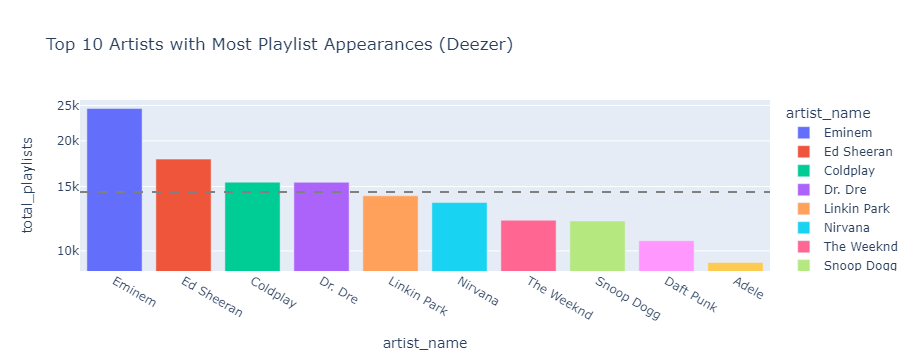

In [ ]:
artist_playlist_counts = exploded_data.groupby('artist_name')['deezer_playlists_count'].sum().reset_index()
artist_playlist_counts['total_playlists'] = artist_playlist_counts['deezer_playlists_count']
top_artists_playlists = artist_playlist_counts.sort_values(by='total_playlists', ascending=False).head(10)
fig_playlist_deezer = px.bar(top_artists_playlists, x='artist_name', y='total_playlists', title='Top 10 Artists with Most Playlist Appearances (Deezer)', color='artist_name')
fig_playlist_deezer.update_layout(yaxis_type="log")
mean_playlist_count = top_artists_playlists['total_playlists'].mean()
fig_playlist_deezer.add_hline(y=mean_playlist_count, line_dash='dash', line_color='grey', annotation_text=f"Mean: {mean_playlist_count:.2f}", annotation_position="top right")
fig_playlist_deezer.show()

# Group and plot playlist appearances Overall

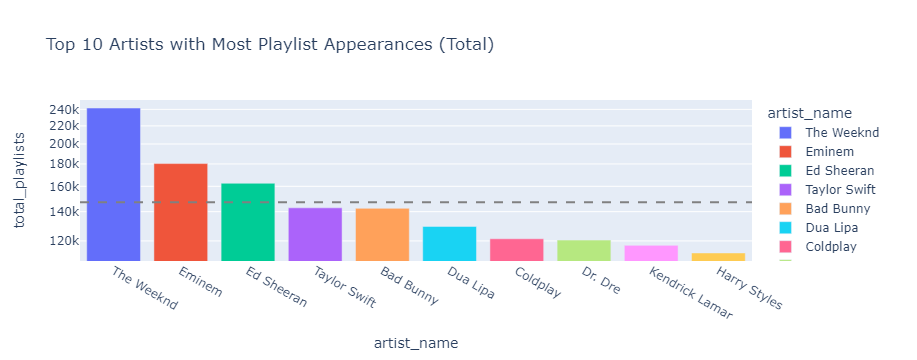

In [ ]:
artist_playlist_counts = exploded_data.groupby('artist_name')[['spotify_playlists_count', 'apple_playlists_count', 'deezer_playlists_count']].sum().reset_index()
artist_playlist_counts['total_playlists'] = artist_playlist_counts['spotify_playlists_count'] + artist_playlist_counts['apple_playlists_count'] + artist_playlist_counts['deezer_playlists_count']
top_artists_playlists = artist_playlist_counts.sort_values(by='total_playlists', ascending=False).head(10)
fig_playlist = px.bar(top_artists_playlists, x='artist_name', y='total_playlists', title='Top 10 Artists with Most Playlist Appearances (Total)', color='artist_name')
fig_playlist.update_layout(yaxis_type="log")
mean_playlist_count = top_artists_playlists['total_playlists'].mean()
fig_playlist.add_hline(y=mean_playlist_count, line_dash='dash', line_color='grey', annotation_text=f"Mean: {mean_playlist_count:.2f}", annotation_position="top right")
fig_playlist.show()

In [ ]:
def kill_process_on_port(port):
    command = f"lsof -t -i:{port}"
    process = os.popen(command)
    result = process.read()
    process.close()
    if result:
        pids = result.split("\n")[:-1]
        for pid in pids:
            os.kill(int(pid), signal.SIGKILL)

# DashBoard for interactive exploration

In [ ]:
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Bruno's Music Dashboard"),

    # Main selector
    dcc.RadioItems(
        id='main-selector',
        options=[
            {'label': 'Artists Numbers', 'value': 'artists-plots'},
            {'label': 'Streaming Services Numbers', 'value': 'streaming-plots'},
            {'label': 'Histogram Selection', 'value': 'hist'},
            {'label': 'Boxplot Selection', 'value': 'boxplot'},
        ],
        value='artists-plots',
        labelStyle={'display': 'block'}
    ),

    # Predefined plots
    html.Div(id='artists-plots-div', children=[
        dcc.Graph(id='plot1', figure=fig_most_tracks),
        dcc.Graph(id='plot2', figure=fig_most_streams),
        dcc.Graph(id='plot3', figure=fig_track_most_streams),
    ]),

    html.Div(id='streaming-plots-div', children=[
        dcc.Graph(id='plot4', figure=fig_playlist_spotify),
        dcc.Graph(id='plot5', figure=fig_playlist_apple),
        dcc.Graph(id='plot6', figure=fig_playlist_deezer),
        # Add more graphs here
    ], style={'display': 'none'}),

    # Histogram selection
    html.Div(id='hist-div', children=[
        html.H3('Column Selection for Histogram:'),
        dcc.Dropdown(
            id='dropdown',
            options=[{'label': x, 'value': x} for x in data.columns if data[x].dtype == 'int64'],
            value='streams',
        ),
        dcc.Graph(id='visual')
    ], style={'display': 'none'}),

    # Boxplot selection
    html.Div(id='boxplot-div', children=[
        html.H3('Column Selection for Boxplot:'),
        dcc.Dropdown(
            id='boxplot-dropdown',
            options=[{'label': x, 'value': x} for x in data.columns if data[x].dtype == 'int64'],
            value='streams'
        ),
        dcc.Graph(id='boxplot-visual')
    ], style={'display': 'none'}),

])

# Callback to toggle between different sections
@app.callback(
    [Output('artists-plots-div', 'style'),
     Output('streaming-plots-div', 'style'),
     Output('hist-div', 'style'),
     Output('boxplot-div', 'style')],
    [Input('main-selector', 'value')]
)
def toggle_layout(selected_value):
    if selected_value == 'artists-plots':
        return {'display': 'block'}, {'display': 'none'}, {'display': 'none'}, {'display': 'none'}
    elif selected_value == 'streaming-plots':
        return {'display': 'none'}, {'display': 'block'}, {'display': 'none'}, {'display': 'none'}
    elif selected_value == 'hist':
        return {'display': 'none'}, {'display': 'none'}, {'display': 'block'}, {'display': 'none'}
    elif selected_value == 'boxplot':
        return {'display': 'none'}, {'display': 'none'}, {'display': 'none'}, {'display': 'block'}

# Callback to update the histogram based on column selection
@app.callback(
    Output('visual', 'figure'),
    [Input('dropdown', 'value')]
)
def update_histogram(selected_column):
    if selected_column:
        return px.histogram(data, x=selected_column).update_layout(width=1000, height=800)
    return {}

# Callback to update the boxplot based on column selection
@app.callback(
    Output('boxplot-visual', 'figure'),
    [Input('boxplot-dropdown', 'value')]
)
def update_boxplot(selected_column):
    if selected_column:
        return px.box(data, y=selected_column).update_layout(width=1000, height=700)
    return {}

# Run the Dash app
if __name__ == '__main__':
    app.run_server(mode='inline', debug=True, port=9013)

# Feature Engineering - Clustering

In [ ]:
data_for_clustering = data.copy()
data_for_clustering['artist_name'] = data_for_clustering['artist_name'].apply(', '.join)

In [ ]:
numeric_features = data_for_clustering.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['artist_name']

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='drop'
)

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



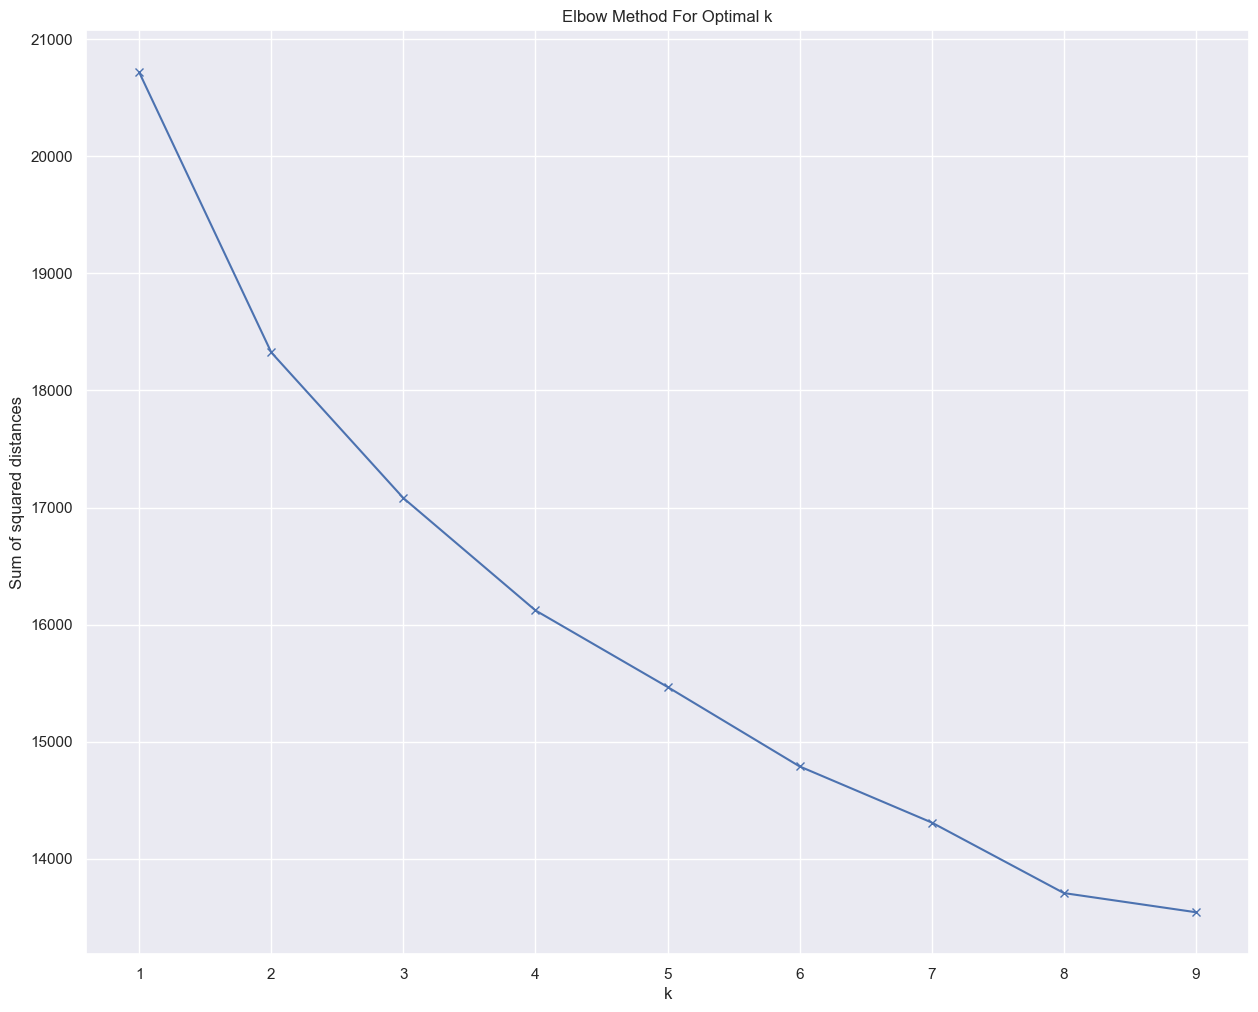

In [ ]:
K = range(1, 10)
X = preprocessor.fit_transform(data_for_clustering)
SSD = []
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    SSD.append(km.inertia_)

plt.plot(K, SSD, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data_for_clustering['cluster'] = kmeans.fit_predict(X)

# Song Recommendation based on searched track

In [ ]:
def recommend_tracks(track_name, num_recommendations=10):
    cluster = data_for_clustering[data_for_clustering['track_name'] == track_name]['cluster'].iloc[0]
    recommendations_data = data_for_clustering[(data_for_clustering['cluster'] == cluster) &
                                               (data_for_clustering['streams'] > 200000) &
                                               (data_for_clustering['track_name'] != track_name)][['track_name', 'artist_name']].head(num_recommendations)
    return recommendations_data

In [ ]:
recommend_tracks('vampire')

,track_name,artist_name
169,When I Was Your Man,Bruno Mars
47,Die For You,The Weeknd
154,Locked Out Of Heaven,Bruno Mars
368,LA CANCIï¿½,"J Balvin, Bad Bunny"
170,Let Me Down Slowly,Alec Benjamin
320,Gangsta's Paradise,"Coolio, L.V."
74,"Quevedo: Bzrp Music Sessions, Vol. 52","Bizarrap, Quevedo"
434,Woman,Doja Cat
790,Callaita,"Bad Bunny, Tainy"
401,Heather,Conan Gray
